In [231]:
from lsmulator import *
from workloads import *
import numpy as np
import matplotlib.pyplot as plt
from figure_grid import *
from bloom_assignments import *
from plot_helpers import *
from mpl_toolkits.mplot3d import Axes3D

# Optimizing Allocation

In [2]:
zipf = ZipfWorkload(zipf_param=1.25)
disc = DiscoverDecayWorkload(creates=scipy.stats.poisson(10), updates=scipy.stats.poisson(8))
unif = UniformWorkload()
rrob = RoundRobinWorkload()

def optimize(workload, total_memory, assignment, dM=100):
  return LSMulator.cache_vs_bloom_vs_buf(workload, total_memory, dM=dM, ballocs=assignment)

## Running the simulation on a grid (cache-buffer-bloom, monkey & baseline)

In [3]:
zipf_monkey = optimize(zipf, 1000, monkey_assignment)
zipf_baseln = optimize(zipf, 1000, baseline_assignment)

In [4]:
disc_monkey = optimize(disc, 1000, monkey_assignment)
disc_baseln = optimize(disc, 1000, baseline_assignment)

In [5]:
unif_monkey = optimize(unif, 1000, monkey_assignment)
unif_baseln = optimize(unif, 1000, baseline_assignment)

In [6]:
rrob_monkey = optimize(rrob, 1000, monkey_assignment)
rrob_baseln = optimize(rrob, 1000, baseline_assignment)

In [234]:
def compare_results(distname):
  dist = eval(distname)
  monkey = eval(distname+'_monkey')
  baseln = eval(distname+'_baseln')
  compare_cbm_contours(monkey, baseln, figsize=(7,3))
  plt.suptitle(dist, y=1.1, fontsize=16)
  plt.show()
  compare_cbm_contours(monkey, baseln, figsize=(7,3), method=plot_cbm_contourf)
  plt.show()
  compare_cbm_trisurfs(monkey, baseln)
  plt.show()

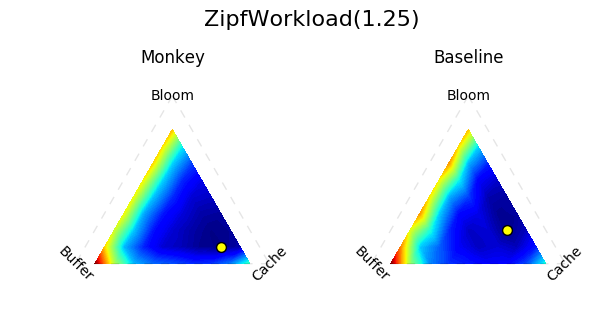

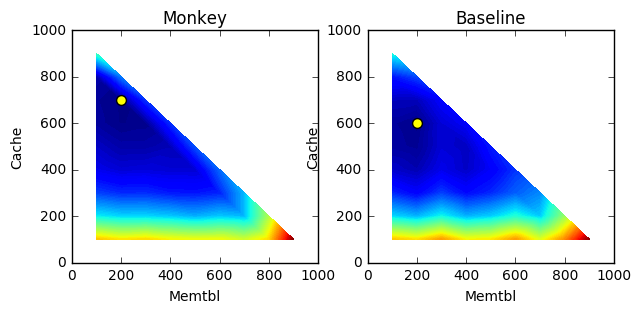

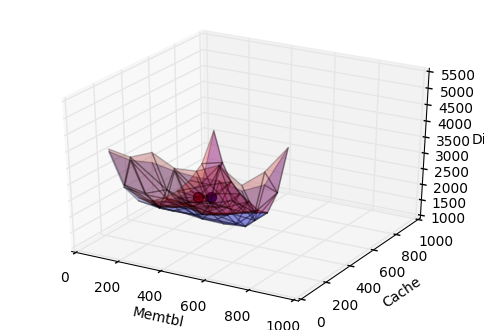

In [235]:
compare_results('zipf')

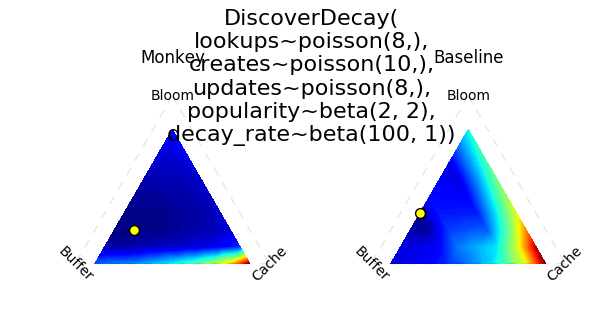

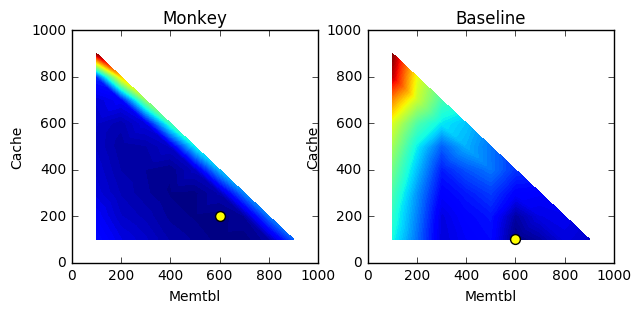

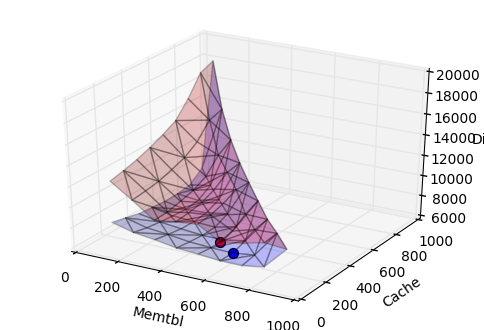

In [237]:
compare_results('disc')

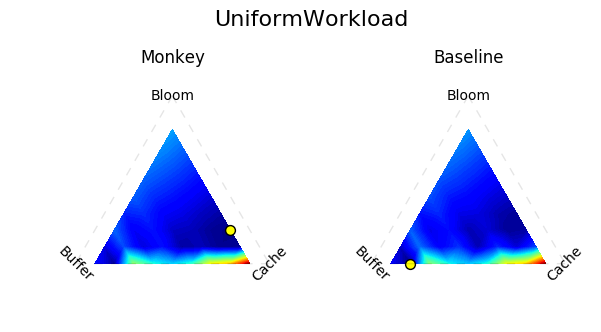

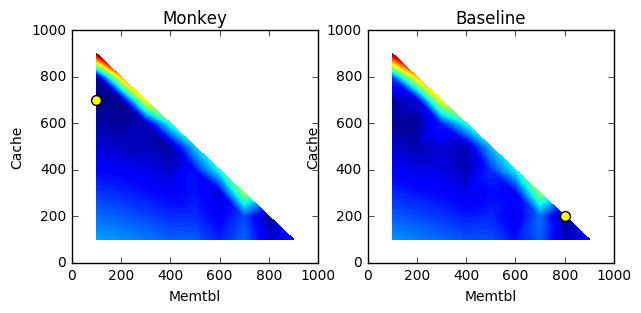

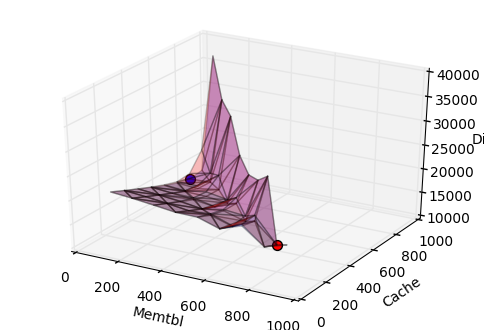

In [236]:
compare_results('unif')

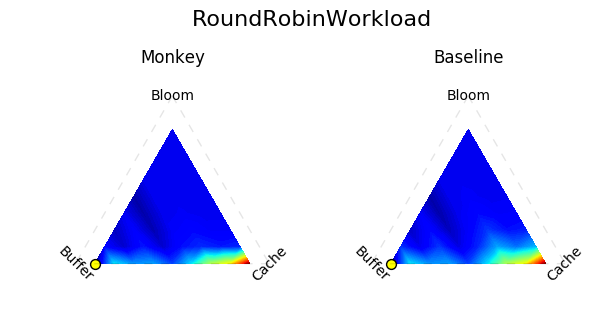

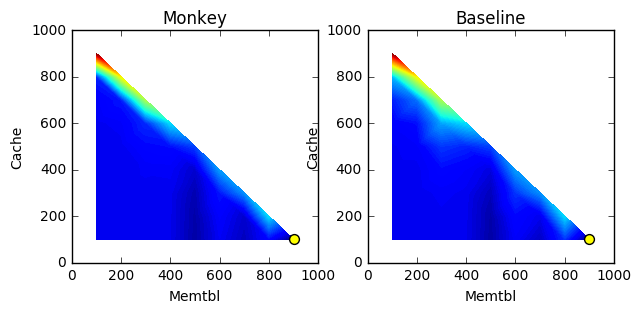

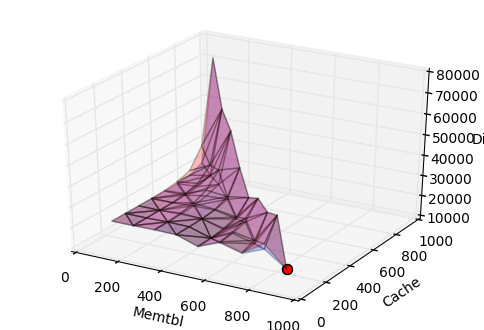

In [238]:
compare_results('rrob')

## Estimating IOs saved by enlarging cache

### What's the variance?

## Estimating IOs saved by enlarging memtable (buffer)

### What's the variance?

## Estimating IOs saved by enlarging bloom filters

### What's the variance?

## Comparing theoretical estimates to simulated results